# Repeating the experiment done in notebook:

### `13-tasty-images-CNN-data-augmentation-model-image-100-1` 

In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import h5py
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 100 by 100.

In [3]:
with open('pre_processed_images/image_data_20000_100.txt', 'rb') as f:
    X, y = pickle.load(f)

In [4]:
datagen = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.4,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')

#### Creating a train, test split.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Creating a validation split out of the training set.

In [6]:
X_train_fit, X_val, y_train_fit, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [7]:
y_train_fit_sparse = np_utils.to_categorical(y_train_fit, 2)

In [8]:
y_val_sparse = np_utils.to_categorical(y_val, 2)

In [9]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [10]:
datagen.fit(X_train)

#### Creating an instance of a CNN model.

##### The image size is 100.

In [11]:
IMG_SIZE = 100

In [12]:
model_1 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [13]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [14]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

In [ ]:
model_1.fit_generator(datagen.flow(X_train_fit, y_train_fit_sparse, batch_size=128), steps_per_epoch=len(X_train_fit), epochs=5, validation_data=(X_val, y_val_sparse))

Epoch 1/5
12600/12600 [==============================] - 15688s - loss: 0.3048 - acc: 0.8751 - val_loss: 0.2544 - val_acc: 0.8957
Epoch 2/5
12600/12600 [==============================] - 16005s - loss: 0.2652 - acc: 0.8983 - val_loss: 0.2493 - val_acc: 0.9000
Epoch 3/5
12600/12600 [==============================] - 15692s - loss: 0.3309 - acc: 0.8728 - val_loss: 0.4137 - val_acc: 0.8543
Epoch 4/5
12600/12600 [==============================] - 15767s - loss: 0.3836 - acc: 0.8502 - val_loss: 0.4283 - val_acc: 0.8250
Epoch 5/5
12600/12600 [==============================] - 16333s - loss: 0.4250 - acc: 0.8309 - val_loss: 0.5634 - val_acc: 0.8321


In [16]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

6000/6000 [==============================] - 20s    


In [17]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.5638
Test accuracy: 84.28%


In [18]:
model_1.save('models/model_v1_20000_100_augmentation.h5')

In [19]:
model_1.save_weights('models/model_v1_20000_100_augmentation_weights.h5')

#### Creating a list of predictions.

In [20]:
predicted_images = []
for i in model_1.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

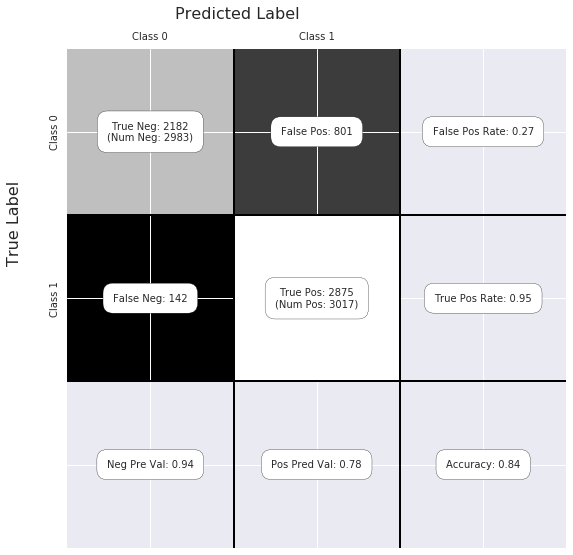

In [21]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [22]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,2182,801
1,142,2875


In [23]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 84.22%



In [24]:
predictions_probability = model_1.predict_proba(X_test)

6000/6000 [==============================] - 20s    


#### Plotting a ROC curve.

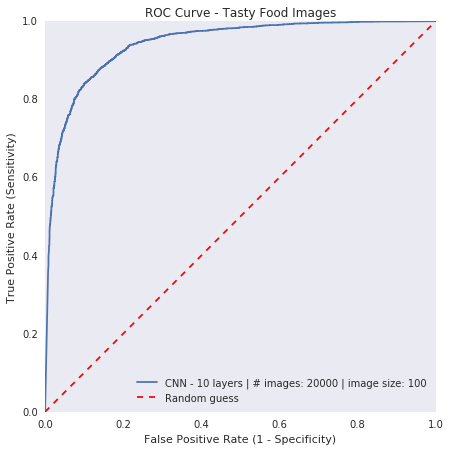

In [25]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

In [26]:
def plot_confusion_matrix(y_true, y_pred):
    cm_array = confusion_matrix(y_true, y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks, pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

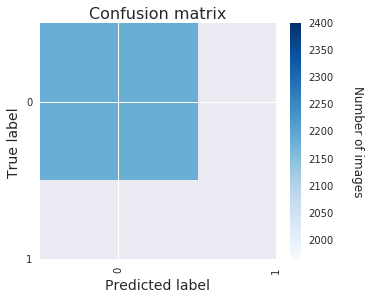

In [27]:
plot_confusion_matrix(y_test, predicted_images)

In [34]:
!gsutil cp -r 'models' 'gs://wellio-kadaif-tasty-images-project-pre-processed-images'

Copying file://models/model_v1_20000_25_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_100_augmentation_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v2_20000_50.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_weights.h5 [Content-Type=application/octet-stream]...
\ [4 files][ 16.5 MiB/ 16.5 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://models/model_v0_20000_25_augmentation_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_100_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_augmentation.h5 [Content-Type=application/o